# MoonBoard grade classification model using Deep Sets

In [1]:
# import modules
import torch    

In [2]:
import numpy as np
import json
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils.rnn import pad_sequence
import os
from modules import ISAB, SAB, PMA

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [3]:
# Mappings --------------------------------------------------------
# Map each hold like "A1"…"K18" to an integer 0…(11*18−1)=197
cols = [chr(c) for c in range(ord('A'), ord('K')+1)]
rows = list(range(1, 19))
hold_to_idx = {f"{c}{r}": i for i, (c, r) in enumerate((c, r) for r in rows for c in cols)}


# Map grades "V4"…"V11" 
grade_to_label = {f"V{i}": i - 4 for i in range(4, 12)}  
label_to_grade = {v: k for k, v in grade_to_label.items()}

In [4]:
# Dataset ---------------------------------------------------------
class MoonBoardDataset(Dataset):
    def __init__(self, json_path, hold_to_idx, grade_to_label, embed_dim):
        self.hold_to_idx = hold_to_idx
        self.grade_to_label = grade_to_label
        self.embedding = nn.Embedding(len(hold_to_idx), embed_dim)
        # load all lines
        with open(json_path, 'r') as f:
            self.raw = [json.loads(line) for line in f]

    def __len__(self):
        return len(self.raw)

    def __getitem__(self, idx):
        item = self.raw[idx]
        try:
            hold_idxs = torch.tensor([self.hold_to_idx[h] for h in item['holds']], dtype=torch.long)
        except KeyError as e:
            print(f"[ERROR] Problem name: {item.get('problem_name', 'UNKNOWN')}")
            print(f"[ERROR] Invalid hold found in item {idx}: {item['holds']}")
            raise e
        holds_emb = self.embedding(hold_idxs)
        label = torch.tensor(self.grade_to_label[item['grade']], dtype=torch.long)
        return holds_emb, label

In [5]:
# Classifier Model -----------------------------------------------

class DeepSetClassifier(nn.Module):
    def __init__(self, dim_input, dim_hidden=128, num_classes=8):  # 8 for V4–V11
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.ReLU(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.ReLU(),
            nn.Linear(dim_hidden, dim_hidden),
        )
        self.decoder = nn.Sequential(
            nn.Linear(dim_hidden, dim_hidden),
            nn.ReLU(),
            nn.Linear(dim_hidden, 1),  # 変更
            nn.Sigmoid()  # 変更
        )

    def forward(self, X):
        # X: (batch_size, num_holds, dim_input)
        X = self.encoder(X)              # (B, N, H)
        X = X.mean(dim=1)               # (B, H) — permutation invariant
        out = self.decoder(X)           # (B, num_classes)
        return out


In [6]:
# Training loop
# --- Hyperparameters ---
json_path = './cleaned_moonboard_problems.json'
embed_dim = 64
batch_size = 16
lr = 1e-4
epochs = 15
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Collate Function ---
def collate_batch(batch):
    X_batch = [x for x, _ in batch]
    y_batch = [y for _, y in batch]
    X_padded = pad_sequence(X_batch, batch_first=True)
    y_tensor = torch.stack(y_batch).float()  # 変更
    return X_padded, y_tensor

# --- Evaluation ---
def evaluate(model, dataloader, device):
    model.eval
    y_true = []  # 変更
    y_pred = []

    with torch.no_grad():  # 変更
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            preds = model(X).squeeze(-1) * 6.0
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Mean Squared Error
    mse = np.mean((y_pred - y_true) ** 2)
    print(f"MSE: {mse:.4f}")

    # ±1 Grade Accuracy
    rounded_preds = np.round(y_pred)
    loose_acc = np.mean(np.abs(rounded_preds - y_true) <= 1.0)
    print(f"±1 Grade Accuracy: {loose_acc * 100:.2f}%")

# --- Dataset Loading ---
def load_dataset(json_path, hold_to_idx, grade_to_label, embed_dim):
    return MoonBoardDataset(json_path, hold_to_idx, grade_to_label, embed_dim)

# --- DataLoader Preparation ---
def prepare_dataloaders(dataset, grade_to_label, batch_size):
    targets = [grade_to_label[item['grade']] for item in dataset.raw]

    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(targets),
        y=targets
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    train_idx, val_idx = train_test_split(
        list(range(len(dataset))),
        test_size=0.2,
        stratify=targets,
        random_state=42
    )

    train_data = Subset(dataset, train_idx)
    val_data = Subset(dataset, val_idx)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

    return train_loader, val_loader, class_weights

# --- Training Function ---
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        for X, y in train_loader:

            X, y = X.to(device), y.to(device)
            y_scaled = y / 6.0  # scale target to [0, 1]
            preds = model(X).squeeze(-1)
            loss = criterion(preds, y_scaled)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch:02d} — loss: {total_loss / len(train_loader):.4f}")

    torch.save(model.state_dict(), 'deepset_moonboard.pth')
    print("Training complete. Model saved.")
    evaluate(model, val_loader, device)

# --- Main ---
def main():
    dataset = load_dataset(json_path, hold_to_idx, grade_to_label, embed_dim)
    train_loader, val_loader, class_weights = prepare_dataloaders(dataset, grade_to_label, batch_size)

    model = DeepSetClassifier(dim_input=embed_dim, num_classes=1).to(device)
    criterion = nn.MSELoss()  # TODO: change to meanssquareerror for regression model
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_model(model, train_loader, val_loader, criterion, optimizer, epochs)
    return val_loader

if __name__ == '__main__':
    val_loader = main()


Epoch 01 — loss: 0.0608
Epoch 02 — loss: 0.0419
Epoch 03 — loss: 0.0399
Epoch 04 — loss: 0.0398
Epoch 05 — loss: 0.0390
Epoch 06 — loss: 0.0388
Epoch 07 — loss: 0.0388
Epoch 08 — loss: 0.0388
Epoch 09 — loss: 0.0385
Epoch 10 — loss: 0.0382
Epoch 11 — loss: 0.0383
Epoch 12 — loss: 0.0384
Epoch 13 — loss: 0.0380
Epoch 14 — loss: 0.0383
Epoch 15 — loss: 0.0380
Training complete. Model saved.
MSE: 1.4318
±1 Grade Accuracy: 80.76%


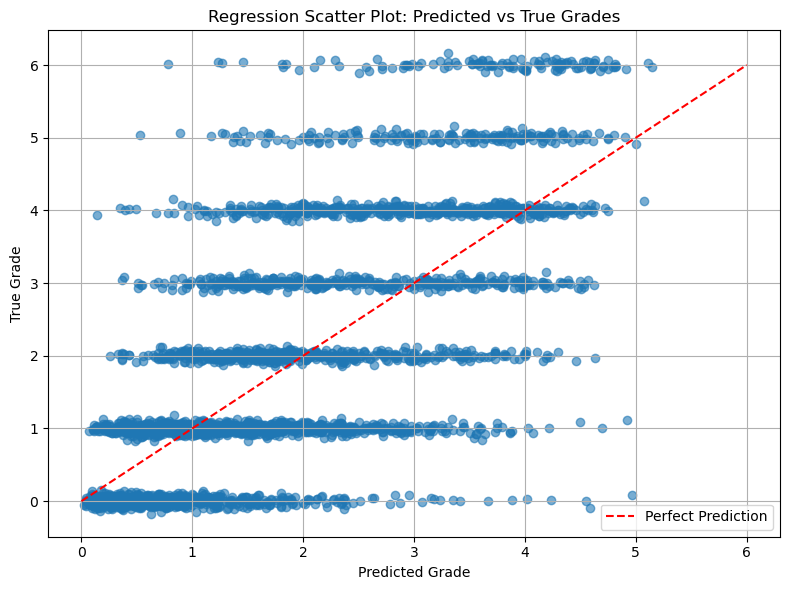

±1 Grade Accuracy: 80.76%


In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_regression_scatter(model, dataloader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            # preds = model(X).squeeze()  # (B, 1) → (B)
            preds = model(X).view(-1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred) * 6.0

    # --- Scatter Plot ---
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, y_true + np.random.normal(0, 0.05, size=len(y_true)), alpha=0.6)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--', label='Perfect Prediction')
    plt.xlabel("Predicted Grade")
    plt.ylabel("True Grade")
    plt.title("Regression Scatter Plot: Predicted vs True Grades")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- ±1 Grade Accuracy: with rounding to match training ---
    rounded_preds = np.round(y_pred)
    loose_acc = np.mean(np.abs(rounded_preds - y_true) <= 1.0)
    print(f"±1 Grade Accuracy: {loose_acc * 100:.2f}%")

# --- Usage ---
model = DeepSetClassifier(dim_input=embed_dim, num_classes=1).to(device)
model.load_state_dict(torch.load("deepset_moonboard.pth", map_location=device))
plot_regression_scatter(model, val_loader, device)
